# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

1684976


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF4_4T1Primary16bit_DNAbit')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit'

In [6]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Load designed pd_dict

In [9]:
# candidate probes
import pickle
candidate_probe_filename = os.path.join(library_folder, '2023_10_18_candidate_probe.pkl')
                                   
print(candidate_probe_filename)
sel_pb_dict = pickle.load(open(candidate_probe_filename, 'rb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/2023_10_18_candidate_probe.pkl


In [10]:
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

In [11]:
sel_pb_dict = {_k:_v for _k,_v in sel_pb_dict.items() if _k in kept_gene_df.index}

In [12]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	2097
Ighd
	ENSMUST00000194162.6	946
Klhl14
	ENSMUST00000122333.2	2032
Tmem252
	ENSMUST00000057243.6	2293
Dab2
	ENSMUST00000080880.12	2101
Camk4
	ENSMUST00000042868.6	1136
Themis
	ENSMUST00000056097.11	1510
Cd200r3
	ENSMUST00000114611.10	653
Gata2
	ENSMUST00000015197.9	1603
Ifng
	ENSMUST00000068592.5	524
Cd96
	ENSMUST00000023336.10	1162
Cd8b1
	ENSMUST00000065248.9	784
Retnlg
	ENSMUST00000065666.6	172
Cd8a
	ENSMUST00000066747.14	1528
Clec14a
	ENSMUST00000062254.4	2030
Pou2af1
	ENSMUST00000034554.9	1166
Col5a2
	ENSMUST00000086430.5	2959
Wnt7b
	ENSMUST00000109424.4	1786
Ibsp
	ENSMUST00000031246.9	847
Htr1b
	ENSMUST00000183482.2	2039
Prex2
	ENSMUST00000027056.12	3748
Ankrd1
	ENSMUST00000237142.2	1157
Robo4
	ENSMUST00000214185.3	3039
Cd4
	ENSMUST00000024044.7	1941
Foxp3
	ENSMUST00000115739.9	2675
Prdm1
	ENSMUST00000039174.11	2405
Hpd
	ENSMUST00000031398.14	1021
Shank3
	ENSMUST00000109309.9	3807
Gpihbp1
	ENSMUST00000023243.11	602
Flt3
	ENSMU

In [13]:
print(len(sel_pb_dict))

124


# Load Codebook

In [14]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
#barcode_table.replace({'name':replace_dict}, inplace=True)
gene_ids = list(kept_gene_df.index)
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Trdc,ENSMUST00000196323.2,1100000011000000
1,Ighd,ENSMUST00000194162.6,0000100110010000
2,Klhl14,ENSMUST00000122333.2,1111000000000000
3,Tmem252,ENSMUST00000057243.6,1010000010100000
4,Dab2,ENSMUST00000080880.12,0010001010001000
...,...,...,...
131,Blank-8,,0000001111000000
132,Blank-9,,0000000010101010
133,Blank-10,,0010001001000100
134,Blank-11,,1100110000000000


# Readouts

In [15]:
# load readouts
print(f"Loading readouts from file: {readout_savefile}")
readouts = pd.read_csv(readout_savefile)

Loading readouts from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/readouts.csv


In [16]:
# modify Stv into standard sequence
readout_seqs = pd.DataFrame(
    {'id':readouts['Name'], 'description':readouts['Name'], 'sequence':[_s[-20:] for _s in readouts['Sequence']]}
)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)

In [17]:
readout_seqs

,id,description,sequence,on-bit
0,Stv_29,Stv_29,CGGCCGGTTGGTCTACGGAT,0
1,Stv_30,Stv_30,GTCTGGAACGACGGATTCAG,1
2,Stv_31,Stv_31,CGGTGCGGTGGGATGGATAA,2
3,Stv_32,Stv_32,CGTTCGTACCGCGTACTTCG,3
4,Stv_33,Stv_33,AGTGCGCACGAGTTGAACTG,4
5,Stv_35,Stv_35,CGCGGCGTGAATATCGCGGC,5
6,Stv_36,Stv_36,TACGGGCCCAGACGTTTCAT,6
7,Stv_37,Stv_37,GTGTCCGCCAGTACCGTGAG,7
8,Stv_39,Stv_39,CCGTATCCCTGGCGCGGACT,8
9,Stv_40,Stv_40,ACGTAAGGCAGCTTGCGTTA,9


In [18]:
# Add the readout sequences. Here we randomly add 4 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readouts_per_probe = 3

rs.add_readout_seqs_to_probes_random(sel_pb_dict, readout_seqs, barcode_table, num_readouts_per_probe, 
                                     n_threads=12,
                                     spacer='A', gene_id_key='name', each_probe_1_on_bit=False) 
# if each_probe_1_on_bit set to be true, each probe will have 4 of the same readout sequence

Added readout sequences to 172 probes.
Added readout sequences to 524 probes.
Added readout sequences to 847 probes.
Added readout sequences to 1166 probes.
Added readout sequences to 1441 probes.
Added readout sequences to 1157 probes.
Added readout sequences to 1510 probes.
Added readout sequences to 1528 probes.
Added readout sequences to 1162 probes.
Added readout sequences to 1406 probes.
Added readout sequences to 2097 probes.
Added readout sequences to 653 probes.
Added readout sequences to 2293 probes.
Added readout sequences to 2675 probes.
Added readout sequences to 784 probes.
Added readout sequences to 946 probes.
Added readout sequences to 1799 probes.
Added readout sequences to 511 probes.
Added readout sequences to 2039 probes.
Added readout sequences to 956 probes.
Added readout sequences to 876 probes.
Added readout sequences to 3807 probes.
Added readout sequences to 2959 probes.Added readout sequences to 2030 probes.

Added readout sequences to 1603 probes.
Added rea

In [19]:
%%time
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(sel_pb_dict, N_probes_per_transcript=96, 
                                   N_on_bits=4, N_threads=12)

Retnlg:ENSMUST00000065666.6: selected 96/172 probes with N_overlapping_bases=9284.0 and on-bit_coverage={9: 72, 2: 74, 5: 71, 14: 71}.
Ifng:ENSMUST00000068592.5: selected 96/524 probes with N_overlapping_bases=3376.0 and on-bit_coverage={10: 71, 3: 73, 14: 71, 7: 73}.
Ibsp:ENSMUST00000031246.9: selected 96/847 probes with N_overlapping_bases=1264.0 and on-bit_coverage={8: 70, 2: 73, 13: 72, 7: 73}.
Pou2af1:ENSMUST00000034554.9: selected 96/1166 probes with N_overlapping_bases=715.0 and on-bit_coverage={4: 71, 5: 73, 14: 73, 15: 71}.
Ankrd1:ENSMUST00000237142.2: selected 96/1157 probes with N_overlapping_bases=1078.0 and on-bit_coverage={1: 71, 3: 72, 12: 72, 14: 73}.
Cyp11a1:ENSMUST00000034874.14: selected 96/1441 probes with N_overlapping_bases=821.0 and on-bit_coverage={8: 73, 9: 72, 4: 71, 5: 72}.
Stxbp6:ENSMUST00000053768.14: selected 96/1406 probes with N_overlapping_bases=237.0 and on-bit_coverage={0: 71, 10: 75, 13: 71, 7: 71}.
Themis:ENSMUST00000056097.11: selected 96/1510 prob

Sdc1:ENSMUST00000020911.14: selected 96/1603 probes with N_overlapping_bases=333.0 and on-bit_coverage={2: 72, 11: 72, 4: 72, 13: 72}.
Gjb1:ENSMUST00000052130.14: selected 96/904 probes with N_overlapping_bases=1556.0 and on-bit_coverage={8: 72, 9: 72, 2: 72, 3: 72}.
Tppp3:ENSMUST00000177126.8: selected 96/807 probes with N_overlapping_bases=2145.0 and on-bit_coverage={0: 73, 9: 71, 10: 71, 3: 73}.
Mrc1:ENSMUST00000028045.4: selected 96/2421 probes with N_overlapping_bases=0.0 and on-bit_coverage={1: 72, 15: 72, 9: 72, 7: 72}.
Arhgef37:ENSMUST00000171629.3: selected 96/3015 probes with N_overlapping_bases=0.0 and on-bit_coverage={4: 72, 13: 72, 14: 72, 7: 72}.
Ptpro:ENSMUST00000077115.13: selected 96/2854 probes with N_overlapping_bases=0.0 and on-bit_coverage={8: 72, 3: 72, 5: 72, 14: 72}.
Fgfbp1:ENSMUST00000199894.2: selected 96/746 probes with N_overlapping_bases=2459.0 and on-bit_coverage={9: 72, 2: 72, 12: 73, 7: 71}.
Zbtb7b:ENSMUST00000029677.9: selected 96/1683 probes with N_ove

Cd300e:ENSMUST00000062787.9: selected 96/1188 probes with N_overlapping_bases=925.0 and on-bit_coverage={8: 72, 1: 72, 2: 72, 11: 72}.
Azgp1:ENSMUST00000035390.7: selected 96/825 probes with N_overlapping_bases=2170.0 and on-bit_coverage={0: 72, 8: 72, 6: 72, 14: 72}.
Fermt1:ENSMUST00000038280.5: selected 96/2820 probes with N_overlapping_bases=0.0 and on-bit_coverage={0: 72, 11: 72, 13: 72, 6: 72}.
Cd22:ENSMUST00000186154.7: selected 96/2661 probes with N_overlapping_bases=11.0 and on-bit_coverage={1: 71, 10: 71, 13: 73, 6: 73}.
CPU times: user 588 ms, sys: 390 ms, total: 978 ms
Wall time: 7min 3s


# Primer

In [20]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [21]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [22]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A07_primer_6'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A12_primer_11'], index=None)

## Add the primer sequences

In [23]:
# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(sel_pb_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(sel_pb_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [24]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
1,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0


# Quality check

In [25]:
sel_pb_dict['Trdc']['ENSMUST00000196323.2']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed
1245,Trdc,ENSMUST00000196323.2,1245,GGCCTGCAAACAACTCACTGTGCAAGTGTT,50.000000,55.085919,0,1.0,0.01,Stv_29:Stv_39::Stv_30,1100000010000000,CGGCCGGTTGGTCTACGGATACCGTATCCCTGGCGCGGACTAGGCC...,CCATTGCCCGCGAGGTCGAGCGGCCGGTTGGTCTACGGATACCGTA...,GGGCCATTGCCCGCGAGGTCGAGCGGCCGGTTGGTCTACGGATACC...
1681,Trdc,ENSMUST00000196323.2,1681,GCAAGGCCACAGCTTTTTGACACACCCACT,53.333333,57.394425,0,1.0,0.01,Stv_30:Stv_40::Stv_39,0100000011000000,GTCTGGAACGACGGATTCAGAACGTAAGGCAGCTTGCGTTAAGCAA...,CCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAACGTA...,GGGCCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAAC...
610,Trdc,ENSMUST00000196323.2,610,CAGCAACAAGCCTAGCTAATCCTCCAGTCT,50.000000,54.204500,0,1.0,0.01,Stv_30:Stv_40::Stv_29,1100000001000000,GTCTGGAACGACGGATTCAGAACGTAAGGCAGCTTGCGTTAACAGC...,CCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAACGTA...,GGGCCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAAC...
1953,Trdc,ENSMUST00000196323.2,1953,GTCTTCTGCCACCCTGCAGCATCCAAATGC,56.666667,57.474127,0,1.0,0.01,Stv_40:Stv_39::Stv_29,1000000011000000,ACGTAAGGCAGCTTGCGTTAACCGTATCCCTGGCGCGGACTAGTCT...,CCATTGCCCGCGAGGTCGAGACGTAAGGCAGCTTGCGTTAACCGTA...,GGGCCATTGCCCGCGAGGTCGAGACGTAAGGCAGCTTGCGTTAACC...
1590,Trdc,ENSMUST00000196323.2,1590,CTGTCTAGGGAACTGGGCCCTGGTTTCCTG,60.000000,59.515611,0,1.0,0.01,Stv_39::Stv_29:Stv_30,1100000010000000,CCGTATCCCTGGCGCGGACTACTGTCTAGGGAACTGGGCCCTGGTT...,CCATTGCCCGCGAGGTCGAGCCGTATCCCTGGCGCGGACTACTGTC...,GGGCCATTGCCCGCGAGGTCGAGCCGTATCCCTGGCGCGGACTACT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Trdc,ENSMUST00000196323.2,2266,GACAACTCTGACCCGCCATGCCAGGAAAAA,53.333333,57.158325,0,1.0,0.01,Stv_39::Stv_29:Stv_30,1100000010000000,CCGTATCCCTGGCGCGGACTAGACAACTCTGACCCGCCATGCCAGG...,CCATTGCCCGCGAGGTCGAGCCGTATCCCTGGCGCGGACTAGACAA...,GGGCCATTGCCCGCGAGGTCGAGCCGTATCCCTGGCGCGGACTAGA...
1142,Trdc,ENSMUST00000196323.2,1142,AATACCGAAAGGAAGGACACTCATTCTGTG,43.333333,50.904922,0,1.0,0.01,Stv_30::Stv_29:Stv_40,1100000001000000,GTCTGGAACGACGGATTCAGAAATACCGAAAGGAAGGACACTCATT...,CCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAAATAC...,GGGCCATTGCCCGCGAGGTCGAGGTCTGGAACGACGGATTCAGAAA...
1560,Trdc,ENSMUST00000196323.2,1560,CACAGCTTCCTGTGCTTCTGGCATTCCATT,50.000000,54.822008,0,1.0,0.01,Stv_29::Stv_39:Stv_30,1100000010000000,CGGCCGGTTGGTCTACGGATACACAGCTTCCTGTGCTTCTGGCATT...,CCATTGCCCGCGAGGTCGAGCGGCCGGTTGGTCTACGGATACACAG...,GGGCCATTGCCCGCGAGGTCGAGCGGCCGGTTGGTCTACGGATACA...
3609,Trdc,ENSMUST00000196323.2,3609,GTGCTCCAGGGGTTTGGGTACAGGCTCCCT,63.333333,63.112861,0,1.0,0.01,Stv_40:Stv_29::Stv_39,1000000011000000,ACGTAAGGCAGCTTGCGTTAACGGCCGGTTGGTCTACGGATAGTGC...,CCATTGCCCGCGAGGTCGAGACGTAAGGCAGCTTGCGTTAACGGCC...,GGGCCATTGCCCGCGAGGTCGAGACGTAAGGCAGCTTGCGTTAACG...


Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

Calculate OTs for 0/124 genes.
Calculate OTs for 1/124 genes.
Calculate OTs for 2/124 genes.
Calculate OTs for 3/124 genes.
Calculate OTs for 4/124 genes.
Calculate OTs for 5/124 genes.
Calculate OTs for 6/124 genes.
Calculate OTs for 7/124 genes.
Calculate OTs for 8/124 genes.
Calculate OTs for 9/124 genes.
Calculate OTs for 10/124 genes.
Calculate OTs for 11/124 genes.
Calculate OTs for 12/124 genes.
Calculate OTs for 13/124 genes.
Calculate OTs for 14/124 genes.
Calculate OTs for 15/124 genes.
Calculate OTs for 16/124 genes.
Calculate OTs for 17/124 genes.
Calculate OTs for 18/124 genes.
Calculate OTs for 19/124 genes.
Calculate OTs for 20/124 genes.
Calculate OTs for 21/124 genes.
Calculate OTs for 22/124 genes.
Calculate OTs for 23/124 genes.
Calculate OTs for 24/124 genes.
Calculate OTs for 25/124 genes.
Calculate OTs for 26/124 genes.
Calculate OTs for 27/124 genes.
Calculate OTs for 28/124 genes.
Calculate OTs for 29/124 genes.
Calculate OTs for 30/124 genes.
Calculate OTs for 

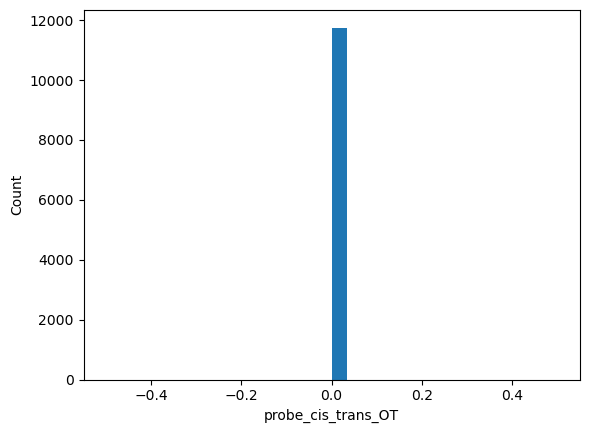

In [26]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(sel_pb_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(sel_pb_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(sel_pb_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(sel_pb_dict, 'probe_cis_trans_OT')

# Output

## default csv output

In [27]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(sel_pb_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(sel_pb_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/designed_probes.csv


In [28]:
len(df_all_probes)

11750

# IDT version output

# Twistbio output

In [29]:
import re, time
from Bio.Seq import reverse_complement

In [30]:
twist_final_probes = pd.DataFrame(
    {
        "name": df_all_probes['probe_names'].values,
        "sequence": df_all_probes['target_readout_primer_sequence_rc'].values,
        "library": ['MF4-4T1_primary_16bit'] * len(df_all_probes),
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit/2023_12_3_twist_probes.xlsx


## Manual checks:

In [31]:
probe_id = 1
twist_final_probes.loc[probe_id,'name']

'Klrk1_ENSMUST00000032252.8_shift:201_GC:43.3_Tm:50.1_specificity:1_isospecificity:0.25_Stv_48:Stv_46::Stv_50'

### readouts

In [40]:
twist_final_probes.loc[probe_id,'sequence'][20:40],\
twist_final_probes.loc[probe_id,'sequence'][72:92],\
twist_final_probes.loc[probe_id,'sequence'][93:113]


('ACGCACGCTCTCTTGCCGTC', 'CTTACACCAGTATCGCGACG', 'ACACGGCATCACGGTCCGGC')

### targeting seq

In [39]:
twist_final_probes.loc[probe_id,'sequence'][41:71]

'TGATGAGACTTTCGATCACGAATCAATGCC'

### primers

In [34]:
twist_final_probes.loc[probe_id,'sequence'][:20]

'CGCAAACTGGTGCGGAAGGC'

In [35]:
twist_final_probes.loc[probe_id,'sequence'][-20:]

'CTCGACCTCGCGGGCAATGG'

In [36]:
len(twist_final_probes.loc[probe_id,'sequence'])

133